In [23]:
from sklearn.model_selection import StratifiedGroupKFold
print(StratifiedGroupKFold)

<class 'sklearn.model_selection._split.StratifiedGroupKFold'>


In [24]:
import torch
import numpy as np

DATA_PATH = "../csi_dataset/csi_windows_w32_s16.pt"  # path ตามของคุณ

obj = torch.load(DATA_PATH, map_location="cpu")

X_all = obj["X"]         # (N, seq_len, n_features) เป็น torch.Tensor
y_all = obj["y"]         # (N,)
groups = obj["group"]    # (N,) group id ต่อ window

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)
print("groups shape:", groups.shape)

if "meta" in obj:
    print("meta:", obj["meta"])

def show_class_dist(name, y):
    y_np = y.cpu().numpy() if isinstance(y, torch.Tensor) else np.array(y)
    uniq, cnt = np.unique(y_np, return_counts=True)
    print(f"{name} class distribution:")
    for u, c in zip(uniq, cnt):
        print(f"  class {u}: {c}")
    print()

show_class_dist("ALL", y_all)

# groups สำหรับ sklearn → ใช้ numpy
if isinstance(groups, torch.Tensor):
    groups = groups.numpy()

print("Unique group ids:", np.unique(groups))
print("Number of groups:", len(np.unique(groups)))

X_all shape: torch.Size([173, 32, 53])
y_all shape: torch.Size([173])
groups shape: torch.Size([173])
meta: {'window_size': 32, 'stride_size': 16}
ALL class distribution:
  class 0: 21
  class 1: 79
  class 2: 73

Unique group ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Number of groups: 15


In [25]:
import numpy as np

def show_group_class_distribution(groups, y_all):
    group_ids = np.unique(groups)
    for g in group_ids:
        mask = (groups == g)
        y_g = y_all[mask]
        y_np = y_g.cpu().numpy() if isinstance(y_g, torch.Tensor) else np.array(y_g)
        uniq, cnt = np.unique(y_np, return_counts=True)
        print(f"\nGroup {g}: total {len(y_g)}")
        for u, c in zip(uniq, cnt):
            print(f"  class {u}: {c}")

show_group_class_distribution(groups, y_all)


Group 0: total 16
  class 2: 16

Group 1: total 14
  class 2: 14

Group 2: total 14
  class 2: 14

Group 3: total 15
  class 2: 15

Group 4: total 14
  class 2: 14

Group 5: total 17
  class 1: 17

Group 6: total 14
  class 1: 14

Group 7: total 16
  class 1: 16

Group 8: total 15
  class 1: 15

Group 9: total 17
  class 1: 17

Group 10: total 4
  class 0: 4

Group 11: total 5
  class 0: 5

Group 12: total 4
  class 0: 4

Group 13: total 4
  class 0: 4

Group 14: total 4
  class 0: 4


In [26]:
from sklearn.model_selection import GroupShuffleSplit

# แปลง groups เป็น numpy สำหรับ sklearn/group indexing
if isinstance(groups, torch.Tensor):
    groups_np = groups.detach().cpu().numpy()
else:
    groups_np = np.asarray(groups)

# แปลง y_all เป็น numpy เฉพาะเพื่อเช็ค class coverage ใน test
if isinstance(y_all, torch.Tensor):
    y_all_np = y_all.detach().cpu().numpy()
else:
    y_all_np = np.asarray(y_all)

required_classes = {0, 1, 2}
selected_random_state = None

for rs in range(201):
    gss = GroupShuffleSplit(test_size=0.15, n_splits=1, random_state=rs)
    temp_idx, test_idx = next(gss.split(X_all, y_all_np, groups=groups_np))
    test_classes = set(np.unique(y_all_np[test_idx]).tolist())

    if required_classes.issubset(test_classes):
        selected_random_state = rs
        break

if selected_random_state is None:
    raise Exception(
        "Could not find a group-aware split with all classes {0,1,2} in TEST for random_state in [0, 200]."
    )

X_temp = X_all[temp_idx]
y_temp = y_all[temp_idx]
groups_temp = groups_np[temp_idx]

X_test = X_all[test_idx]
y_test = y_all[test_idx]
groups_test = groups_np[test_idx]

print("Selected random_state:", selected_random_state)
print("X_temp:", X_temp.shape)
print("X_test:", X_test.shape)

show_class_dist("TEMP", y_temp)
show_class_dist("TEST", y_test)

print("TEMP groups:", np.unique(groups_temp))
print("TEST groups:", np.unique(groups_test))

Selected random_state: 2
X_temp: torch.Size([137, 32, 53])
X_test: torch.Size([36, 32, 53])
TEMP class distribution:
  class 0: 16
  class 1: 62
  class 2: 59

TEST class distribution:
  class 0: 5
  class 1: 17
  class 2: 14

TEMP groups: [ 0  1  2  3  6  7  8  9 10 12 13 14]
TEST groups: [ 4  5 11]


In [27]:
from torch.utils.data import Dataset, DataLoader

class CSIDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].float()
        y = self.y[idx].long()
        return x, y

DEVICE = "mps" if torch.backends.mps.is_available() else \
         "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

BATCH_SIZE = 16

DEVICE: mps


In [28]:
import torch.nn as nn
import torch

seq_len = X_all.shape[1]
input_size = X_all.shape[2]
num_classes = int(len(torch.unique(y_all)))

print("seq_len   :", seq_len)
print("input_size:", input_size)
print("num_classes:", num_classes)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, num_classes=3, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)   # (B, T, H)
        out = out[:, -1, :]     # last timestep
        out = self.fc(out)      # (B, C)
        return out

def train_one_fold(X_train_fold, y_train_fold, X_val_fold, y_val_fold,
                   hidden_size=64, num_layers=1, lr=1e-3, epochs=20):
    model = LSTMClassifier(
        input_size=input_size,
        hidden_size=hidden_size,
        num_layers=num_layers,
        num_classes=num_classes
    ).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_ds = CSIDataset(X_train_fold, y_train_fold)
    val_ds   = CSIDataset(X_val_fold,   y_val_fold)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

    for epoch in range(1, epochs + 1):
        # ----- train -----
        model.train()
        correct = 0
        total = 0
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)

        train_acc = correct / total

        # ----- val -----
        model.eval()
        v_correct = 0
        v_total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)
                logits = model(xb)
                preds = logits.argmax(dim=1)
                v_correct += (preds == yb).sum().item()
                v_total   += yb.size(0)

        val_acc = v_correct / v_total

        print(f"  Epoch {epoch:02d} | train_acc={train_acc:.4f} | val_acc={val_acc:.4f}")

    return model, val_acc

seq_len   : 32
input_size: 53
num_classes: 3


In [35]:
from sklearn.model_selection import StratifiedGroupKFold

K = 5
cv = StratifiedGroupKFold(
    n_splits=K,
    shuffle=True,
    random_state=42,  # fix seed เพื่อ reproducible
)

val_scores = []

print("===== StratifiedGroupKFold on TEMP (85% of data) =====")

# สำคัญ: ใช้ X_temp, y_temp, groups_temp (ไม่ใช่ X_all)
for fold, (tr_idx, va_idx) in enumerate(cv.split(X_temp, y_temp, groups=groups_temp)):
    print(f"\n=== Fold {fold} ===")
    X_train_fold = X_temp[tr_idx]
    y_train_fold = y_temp[tr_idx]
    X_val_fold   = X_temp[va_idx]
    y_val_fold   = y_temp[va_idx]

    print("Train fold size:", len(X_train_fold))
    print("Val   fold size:", len(X_val_fold))

    _, val_acc = train_one_fold(
        X_train_fold, y_train_fold,
        X_val_fold,   y_val_fold,
        hidden_size=64,
        num_layers=1,
        lr=1e-3,
        epochs=20,
    )

    val_scores.append(val_acc)

print("\nValidation accuracy per fold:", val_scores)
print("Mean val accuracy over folds:", np.mean(val_scores))
print("Std  val accuracy over folds:", np.std(val_scores))


train_groups = set(groups_temp[tr_idx])
val_groups = set(groups_temp[va_idx])

intersection = train_groups.intersection(val_groups)

print("Overlap groups:", intersection)

===== StratifiedGroupKFold on TEMP (85% of data) =====

=== Fold 0 ===
Train fold size: 119
Val   fold size: 18
  Epoch 01 | train_acc=0.5798 | val_acc=0.6111
  Epoch 02 | train_acc=0.8655 | val_acc=0.5000
  Epoch 03 | train_acc=0.8571 | val_acc=0.4444
  Epoch 04 | train_acc=0.8824 | val_acc=0.7778
  Epoch 05 | train_acc=0.8908 | val_acc=0.7222
  Epoch 06 | train_acc=0.8739 | val_acc=0.3333
  Epoch 07 | train_acc=0.8571 | val_acc=0.5556
  Epoch 08 | train_acc=0.8908 | val_acc=0.6667
  Epoch 09 | train_acc=0.8908 | val_acc=0.7222
  Epoch 10 | train_acc=0.8908 | val_acc=0.7778
  Epoch 11 | train_acc=0.9244 | val_acc=1.0000
  Epoch 12 | train_acc=0.9916 | val_acc=0.9444
  Epoch 13 | train_acc=0.9916 | val_acc=1.0000
  Epoch 14 | train_acc=1.0000 | val_acc=1.0000
  Epoch 15 | train_acc=1.0000 | val_acc=1.0000
  Epoch 16 | train_acc=1.0000 | val_acc=1.0000
  Epoch 17 | train_acc=1.0000 | val_acc=1.0000
  Epoch 18 | train_acc=1.0000 | val_acc=1.0000
  Epoch 19 | train_acc=1.0000 | val_acc=1.

In [30]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import torch
from torch.utils.data import DataLoader

input_size = X_temp.shape[2]
num_classes = 3
EPOCHS = 20          # จะใช้เท่าของเดิมก่อน
BATCH_SIZE = 16
LR = 1e-3            # fix lr ไว้ก่อน ค่อยเล่นทีหลังได้

# กำหนดชุด hyperparameters ที่จะลอง
hyperparam_configs = [
    {"name": "h64_l1",  "hidden_size": 64,  "num_layers": 1},
    {"name": "h64_l2",  "hidden_size": 64,  "num_layers": 2},
    {"name": "h128_l1", "hidden_size": 128, "num_layers": 1},
    {"name": "h128_l2", "hidden_size": 128, "num_layers": 2},
]

In [31]:
y_temp_np = y_temp.cpu().numpy() if isinstance(y_temp, torch.Tensor) else np.array(y_temp)

results = []  # เอาไว้เก็บผลลัพธ์ของแต่ละ config

for cfg in hyperparam_configs:
    print("\n==============================")
    print(f"Config: {cfg['name']} | hidden={cfg['hidden_size']} | layers={cfg['num_layers']}")
    print("==============================")

    # สร้าง KFold ใหม่สำหรับ config นี้ (หรือจะใช้ตัวเดิมก็ได้)
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_val_accs = []
    fold_idx = 0

    for train_idx, val_idx in kfold.split(np.zeros(len(y_temp_np)), y_temp_np):
        print(f"\n===== Fold {fold_idx} =====")

        X_train_fold = X_temp[train_idx]
        y_train_fold = y_temp[train_idx]
        X_val_fold   = X_temp[val_idx]
        y_val_fold   = y_temp[val_idx]

        print("  Train fold size:", len(X_train_fold))
        print("  Val   fold size:", len(X_val_fold))

        # Dataset / DataLoader
        train_ds = CSIDataset(X_train_fold, y_train_fold)
        val_ds   = CSIDataset(X_val_fold,   y_val_fold)

        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)

        # สร้าง model ใหม่สำหรับ fold นี้
        model = LSTMClassifier(
            input_size=input_size,
            hidden_size=cfg["hidden_size"],
            num_layers=cfg["num_layers"],
            num_classes=num_classes
        ).to(DEVICE)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=LR)

        # ===== Train บน fold นี้ =====
        for epoch in range(1, EPOCHS + 1):
            model.train()
            correct = 0
            total = 0

            for xb, yb in train_loader:
                xb = xb.to(DEVICE)
                yb = yb.to(DEVICE)

                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

            train_acc = correct / total

            # วัด val accuracy
            model.eval()
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for xb, yb in val_loader:
                    xb = xb.to(DEVICE)
                    logits = model(xb)
                    preds = logits.argmax(dim=1).cpu()
                    val_correct += (preds == yb).sum().item()
                    val_total += yb.size(0)

            val_acc = val_correct / val_total

            print(f"  Fold {fold_idx} Epoch {epoch:02d} | train_acc={train_acc:.3f} | val_acc={val_acc:.3f}")

        # ใช้ val_acc ของ epoch สุดท้ายเป็นตัวแทน fold นี้ (เวอร์ชันง่าย)
        fold_val_accs.append(val_acc)
        fold_idx += 1

    mean_val = float(np.mean(fold_val_accs))
    std_val  = float(np.std(fold_val_accs))
    print("\n>>> Config", cfg["name"], "fold val accs:", [round(a, 3) for a in fold_val_accs])
    print(">>> Mean val accuracy:", round(mean_val, 4), "| Std:", round(std_val, 4))

    results.append({
        "name": cfg["name"],
        "hidden_size": cfg["hidden_size"],
        "num_layers": cfg["num_layers"],
        "mean_val_acc": mean_val,
        "std_val_acc": std_val,
    })

print("\n================ FINAL SUMMARY ================\n")
for r in results:
    print(f"{r['name']}: hidden={r['hidden_size']}, layers={r['num_layers']}, "
          f"mean_val_acc={r['mean_val_acc']:.4f}, std={r['std_val_acc']:.4f}")


Config: h64_l1 | hidden=64 | layers=1

===== Fold 0 =====
  Train fold size: 109
  Val   fold size: 28
  Fold 0 Epoch 01 | train_acc=0.670 | val_acc=0.750
  Fold 0 Epoch 02 | train_acc=0.817 | val_acc=0.857
  Fold 0 Epoch 03 | train_acc=0.872 | val_acc=0.893
  Fold 0 Epoch 04 | train_acc=0.826 | val_acc=0.857
  Fold 0 Epoch 05 | train_acc=0.972 | val_acc=0.893
  Fold 0 Epoch 06 | train_acc=0.963 | val_acc=1.000
  Fold 0 Epoch 07 | train_acc=0.963 | val_acc=1.000
  Fold 0 Epoch 08 | train_acc=0.945 | val_acc=1.000
  Fold 0 Epoch 09 | train_acc=0.982 | val_acc=0.929
  Fold 0 Epoch 10 | train_acc=0.936 | val_acc=0.964
  Fold 0 Epoch 11 | train_acc=0.982 | val_acc=0.964
  Fold 0 Epoch 12 | train_acc=0.982 | val_acc=1.000
  Fold 0 Epoch 13 | train_acc=0.991 | val_acc=1.000
  Fold 0 Epoch 14 | train_acc=0.991 | val_acc=1.000
  Fold 0 Epoch 15 | train_acc=1.000 | val_acc=0.964
  Fold 0 Epoch 16 | train_acc=1.000 | val_acc=1.000
  Fold 0 Epoch 17 | train_acc=1.000 | val_acc=1.000
  Fold 0 Epo

In [32]:
# สร้าง DataLoader สำหรับ train_full และ test
train_full_ds = CSIDataset(X_temp, y_temp)
train_full_loader = DataLoader(train_full_ds, batch_size=BATCH_SIZE, shuffle=True)

test_ds = CSIDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# final model
final_model = LSTMClassifier(
    input_size=input_size,
    hidden_size=64,
    num_layers=1,
    num_classes=num_classes
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=1e-3)

EPOCHS_FINAL = 30
for epoch in range(1, EPOCHS_FINAL + 1):
    final_model.train()
    correct = 0
    total = 0
    for xb, yb in train_full_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad()
        logits = final_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)

    train_acc = correct / total
    print(f"Final-Train Epoch {epoch:02d} | train_acc={train_acc:.4f}")

Final-Train Epoch 01 | train_acc=0.6788
Final-Train Epoch 02 | train_acc=0.8248
Final-Train Epoch 03 | train_acc=0.8540
Final-Train Epoch 04 | train_acc=0.8759
Final-Train Epoch 05 | train_acc=0.9270
Final-Train Epoch 06 | train_acc=0.9051
Final-Train Epoch 07 | train_acc=1.0000
Final-Train Epoch 08 | train_acc=1.0000
Final-Train Epoch 09 | train_acc=0.9927
Final-Train Epoch 10 | train_acc=1.0000
Final-Train Epoch 11 | train_acc=0.9854
Final-Train Epoch 12 | train_acc=0.9927
Final-Train Epoch 13 | train_acc=1.0000
Final-Train Epoch 14 | train_acc=1.0000
Final-Train Epoch 15 | train_acc=1.0000
Final-Train Epoch 16 | train_acc=1.0000
Final-Train Epoch 17 | train_acc=0.9927
Final-Train Epoch 18 | train_acc=1.0000
Final-Train Epoch 19 | train_acc=1.0000
Final-Train Epoch 20 | train_acc=0.9927
Final-Train Epoch 21 | train_acc=0.9927
Final-Train Epoch 22 | train_acc=0.9927
Final-Train Epoch 23 | train_acc=0.9927
Final-Train Epoch 24 | train_acc=0.9927
Final-Train Epoch 25 | train_acc=0.9927



🎯 Final TEST accuracy: 1.0000

Confusion Matrix:
 [[ 5  0  0]
 [ 0 17  0]
 [ 0  0 14]]

Classification Report:

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         5
           1     1.0000    1.0000    1.0000        17
           2     1.0000    1.0000    1.0000        14

    accuracy                         1.0000        36
   macro avg     1.0000    1.0000    1.0000        36
weighted avg     1.0000    1.0000    1.0000        36



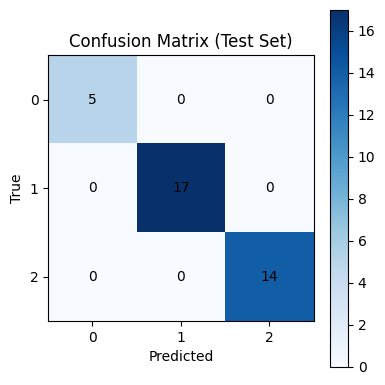

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

final_model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = final_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_true.extend(yb.numpy())

all_preds = np.array(all_preds)
all_true = np.array(all_true)

test_acc = (all_preds == all_true).mean()
print(f"\n🎯 Final TEST accuracy: {test_acc:.4f}\n")

cm = confusion_matrix(all_true, all_preds)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:\n")
print(classification_report(all_true, all_preds, digits=4))

plt.figure(figsize=(4,4))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center", color="black")
plt.xticks(range(num_classes), range(num_classes))
plt.yticks(range(num_classes), range(num_classes))
plt.colorbar()
plt.tight_layout()
plt.show()

In [34]:
import torch

SAVE_PATH = "../lstm/csi_lstm_group85_test15.pt"

checkpoint = {
    "model_state_dict": final_model.state_dict(),
    "input_size": input_size,
    "hidden_size": 64,
    "num_layers": 1,
    "num_classes": num_classes,
    "class_names": ["no_human", "static", "movement"],  # ปรับตาม label mapping จริงของคุณ
    "meta": {
        "split_strategy": "GroupShuffleSplit 85/15",
        "window_size": obj["meta"]["window_size"] if "meta" in obj else None,
        "stride_size": obj["meta"]["stride_size"] if "meta" in obj else None,
    }
}

torch.save(checkpoint, SAVE_PATH)

print("✅ Model saved to:", SAVE_PATH)

✅ Model saved to: ../lstm/csi_lstm_group85_test15.pt
